In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
# import hamiltonian_qutip as hamiltonian
# import parameters_qutip as parameters
import hamiltonian_DJT as hamiltonian
import parameters_DJT as parameters


In [2]:
# Helper function for unit conversion
def tesla_to_GHz(B_tesla):
    """Convert magnetic field from Tesla to GHz using electron gyromagnetic ratio."""
    mu_B = 13.99624555e9  # Bohr magneton in GHz/T
    g_e = 2.00208  # electron g-factor
    return mu_B * g_e * B_tesla  # Returns B in units of g_e * mu_B

# Plot parameters
f_units = 1e9
S_nuclear = 1/2
intensity = 1.0
linewidth = 0.080  # in GHz

# strain parameters
alpha = 80.0 # Strain parameter in GHz
beta = 0.0

C:\Users\56430\AppData\Local\Temp/ipykernel_8976/2507265385.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot_axis[0].pcolormesh(f, thetas, ple_spectra_theta)
C:\Users\56430\AppData\Local\Temp/ipykernel_8976/2507265385.py:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot_axis[1].pcolormesh(f, phis, ple_spectra_phi)


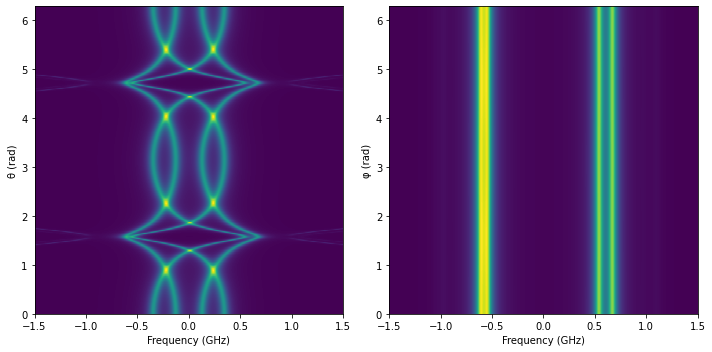

In [3]:
# PLE Spectrum calculations
B_abs = np.array([tesla_to_GHz(0.29)/f_units])

# Along theta (sweep theta with fixed phi)
phi_b = np.pi/10 * 0.0 # Fixed phi
f = np.linspace(-1.5, 1.5, 3001)
thetas = np.linspace(0, 2*np.pi, 501)
ple_spectra_theta = []
for theta in thetas:
    simulated_290mT = hamiltonian.PLE_spectrum(
                f_meas=f, B=B_abs, theta=theta, phi=phi_b, 
                eta = np.array([1,0,1]), intensity=1.0, lw=0.080, 
                alpha=alpha, beta=beta, alpha_exc=alpha, beta_exc=beta
    )

    ple_spectra_theta.append(simulated_290mT.squeeze())


# Along phi (sweep phi with fixed theta)
theta_b = np.pi/2  # Fixed theta
phis = np.linspace(0, 2*np.pi, 501)
ple_spectra_phi = []
for phi in phis:
    simulated_290mT = hamiltonian.PLE_spectrum(
                f_meas=f, B=B_abs, theta=theta_b, phi=phi, 
                eta = np.array([1,0,1]), intensity=1.0, lw=0.080, 
                alpha=alpha, beta=beta, alpha_exc=alpha, beta_exc=beta
    )
    ple_spectra_phi.append(simulated_290mT.squeeze())

# Plot results
fig, plot_axis = plt.subplots(1, 2, figsize=(5*2, 5))
plot_axis[0].pcolormesh(f, thetas, ple_spectra_theta)
plot_axis[1].pcolormesh(f, phis, ple_spectra_phi)

for i in range(2):
    plot_axis[i].set_xlabel('Frequency (GHz)')
    # plot_axis[i].set_xticks([-1.0 + 0.2*i for i in range(11)], minor=True)
    # plot_axis[i].set_yticks([0 + 0.25*i for i in range(26)], minor=True)
plot_axis[0].set_ylabel('θ (rad)')
plot_axis[1].set_ylabel('φ (rad)')

plt.tight_layout()
plt.show()

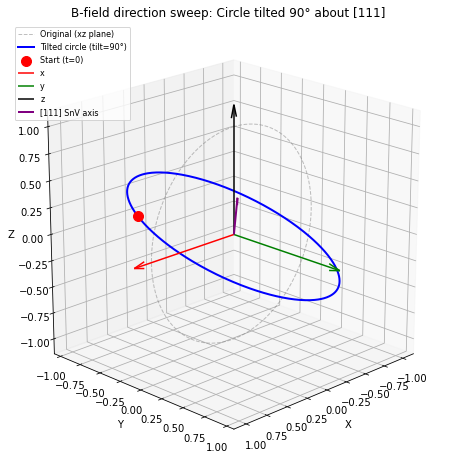

Original circle: θ ∈ [0°, 180°], φ = 0° or 180° (xz plane)
Tilted circle:   θ ∈ [65.6°, 114.4°]
                 φ ∈ [-179.9°, 179.4°]


In [4]:
def tilted_circle_angles(t, tilt, tilt_axis='x'):
    """
    Parameterize a great circle tilted from the xz plane.
    
    Parameters:
        t: array of parameter values from 0 to 2π (goes around the circle)
        tilt: angle of tilt in radians (0 = xz plane)
        tilt_axis: axis to tilt about:
            - 'x', 'y', 'z': Cartesian axes
            - '111': SnV [111] crystallographic axis = (1,1,1)/√3
            - array-like [nx, ny, nz]: arbitrary unit vector
    
    Returns:
        theta, phi: spherical coordinates along the tilted circle
    """
    # Start with a great circle in the xz plane
    x = np.sin(t)
    y = np.zeros_like(t)
    z = np.cos(t)
    
    # Define rotation axis
    if tilt_axis == 'x':
        n = np.array([1, 0, 0])
    elif tilt_axis == 'y':
        n = np.array([0, 1, 0])
    elif tilt_axis == 'z':
        n = np.array([0, 0, 1])
    elif tilt_axis == '111':
        # SnV [111] axis (normalized)
        n = np.array([1, 1, 1]) / np.sqrt(3)
    else:
        # Arbitrary axis (normalize it)
        n = np.array(tilt_axis)
        n = n / np.linalg.norm(n)
    
    # Rodrigues' rotation formula for rotation about arbitrary axis n by angle tilt
    # R(v) = v*cos(tilt) + (n × v)*sin(tilt) + n*(n·v)*(1 - cos(tilt))
    cos_t = np.cos(tilt)
    sin_t = np.sin(tilt)
    
    # Apply rotation to each point
    x_rot = np.zeros_like(t)
    y_rot = np.zeros_like(t)
    z_rot = np.zeros_like(t)
    
    for i in range(len(t)):
        v = np.array([x[i], y[i], z[i]])
        # Cross product n × v
        cross = np.array([
            n[1]*v[2] - n[2]*v[1],
            n[2]*v[0] - n[0]*v[2],
            n[0]*v[1] - n[1]*v[0]
        ])
        # Dot product n · v
        dot = n[0]*v[0] + n[1]*v[1] + n[2]*v[2]
        # Rodrigues formula
        v_rot = v * cos_t + cross * sin_t + n * dot * (1 - cos_t)
        x_rot[i], y_rot[i], z_rot[i] = v_rot
    
    # Convert back to spherical coordinates
    # Handle numerical issues at poles
    z_rot = np.clip(z_rot, -1, 1)
    theta = np.arccos(z_rot)
    phi = np.arctan2(y_rot, x_rot)
    
    return theta, phi

# Example: Sweep a circle tilted from xz plane (about [111] SnV axis)
tilt_angle = np.pi / 2  # Use larger angle to see the effect clearly
t_param = np.linspace(0, 2*np.pi, 501)

# Original circle (no tilt) - in xz plane
theta_original, phi_original = tilted_circle_angles(t_param, 0, tilt_axis='111')

# Tilted circle
theta_tilted, phi_tilted = tilted_circle_angles(t_param, tilt_angle, tilt_axis='111')

# Visualize the tilted circle path on a unit sphere
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Original circle (xz plane) for comparison
x_orig = np.sin(theta_original) * np.cos(phi_original)
y_orig = np.sin(theta_original) * np.sin(phi_original)
z_orig = np.cos(theta_original)
ax.plot(x_orig, y_orig, z_orig, 'gray', linewidth=1, linestyle='--', alpha=0.5, label='Original (xz plane)')

# Tilted circle
x_path = np.sin(theta_tilted) * np.cos(phi_tilted)
y_path = np.sin(theta_tilted) * np.sin(phi_tilted)
z_path = np.cos(theta_tilted)
ax.plot(x_path, y_path, z_path, 'b-', linewidth=2, label=f'Tilted circle (tilt={np.degrees(tilt_angle):.0f}°)')

# Mark the start point (t=0) on tilted circle
ax.scatter([x_path[0]], [y_path[0]], [z_path[0]], color='red', s=100, label='Start (t=0)')

# Add reference axes
ax.quiver(0, 0, 0, 1.2, 0, 0, color='r', arrow_length_ratio=0.1, label='x')
ax.quiver(0, 0, 0, 0, 1.2, 0, color='g', arrow_length_ratio=0.1, label='y')
ax.quiver(0, 0, 0, 0, 0, 1.2, color='k', arrow_length_ratio=0.1, label='z')
# Add [111] SnV axis
n111 = 1.2 / np.sqrt(3)
ax.quiver(0, 0, 0, n111, n111, n111, color='purple', arrow_length_ratio=0.1, linewidth=2, label='[111] SnV axis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'B-field direction sweep: Circle tilted {np.degrees(tilt_angle):.0f}° about [111]')
ax.legend(loc='upper left', fontsize=8)
ax.set_box_aspect([1,1,1])

# Set viewing angle for better visualization
ax.view_init(elev=20, azim=45)
plt.show()

print(f"Original circle: θ ∈ [0°, 180°], φ = 0° or 180° (xz plane)")
print(f"Tilted circle:   θ ∈ [{np.degrees(theta_tilted.min()):.1f}°, {np.degrees(theta_tilted.max()):.1f}°]")
print(f"                 φ ∈ [{np.degrees(phi_tilted.min()):.1f}°, {np.degrees(phi_tilted.max()):.1f}°]")


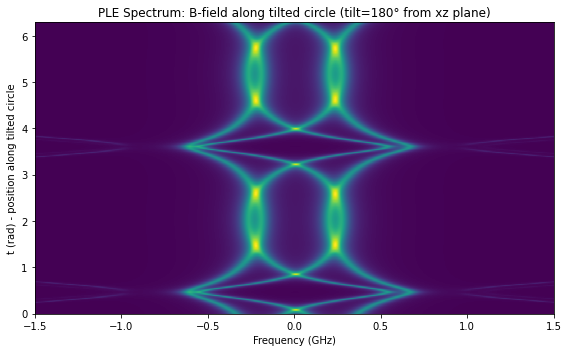

In [5]:
# PLE spectrum along a tilted circle
# Circle is π/40 (4.5°) tilted about the [111] SnV axis
tilt_angle = np.pi 
t_sweep = np.linspace(0, 2*np.pi, 501)
theta_sweep, phi_sweep = tilted_circle_angles(t_sweep, tilt_angle, tilt_axis='111')

ple_spectra_tilted = []
for i in range(len(t_sweep)):
    simulated = hamiltonian.PLE_spectrum(
        f_meas=f, B=B_abs, theta=theta_sweep[i], phi=phi_sweep[i], 
        eta=np.array([1, 0, 1]), intensity=1.0, lw=0.080, 
        alpha=alpha, beta=beta, alpha_exc=alpha, beta_exc=beta
    )
    ple_spectra_tilted.append(simulated.squeeze())

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.pcolormesh(f, t_sweep, ple_spectra_tilted, shading='auto')
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('t (rad) - position along tilted circle')
ax.set_title(f'PLE Spectrum: B-field along tilted circle (tilt={np.degrees(tilt_angle):.0f}° from xz plane)')
plt.tight_layout()
plt.show()
